In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from tsai.all import *
from openavalancheproject.tsai_utilities import *
from bayes_opt import BayesianOptimization

In [3]:
data_root = '/media/scottcha/E1/Data/OAPMLData/'

ml_path = data_root + '/5.MLData/'
num_features = 978
interpolation = 1

In [4]:
interesting_labels =  ['Day1DangerAboveTreeline',
                         'Day1DangerBelowTreeline',
                         'Day1DangerNearTreeline']

In [5]:
class TSStandardizeNanMeanReplaceNan(Transform):
    #method to standardize each batch while also replacing any nans with the mean value before standarization
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, feature_means=None, std=None, feature_std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.feature_means = feature_means
        self.feature_std = feature_std
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
            x, *_ = dl.one_batch()
            x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        fill_values = torch.zeros_like(x)
        std_values = torch.zeros_like(x)       
        for i in range(0,x.shape[1]):
            fill_values[:,i,:] = torch.full_like(x[:,i,:], self.feature_means[i])
            std_values[:,i,:] = torch.full_like(x[:,i,:], self.feature_std[i])
        
        x = torch.where(torch.isnan(x), fill_values, x)
        
        if self.by_sample:        
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            
        t = (x - fill_values) / std_values
        del fill_values, std_values
        return torch.where(torch.isnan(t), torch.zeros_like(t), t)

In [6]:
l = interesting_labels[0]
print('On: ' + l)
label = l
file_label = 'co_' + l + '_small'
fname = ml_path + '/X_all_' + file_label + '.npy'
#mlflow.set_experiment(file_label)

        
X = np.load(fname, mmap_mode='r')
X = X[:,:,:]
utils = TSAIUtilities(X, label)
means_fn = ml_path + '/feature_means_interpolation' + str(interpolation) + '_' + file_label + 'x.npy'
std_fn = ml_path + '/feature_std_interpolation' + str(interpolation)  + '_' + file_label +   'x.npy'
feature_means = utils.get_feature_means(from_cache=means_fn)
feature_std = utils.get_feature_std(from_cache=std_fn)
i = 0
y_train_df = pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet')  
y_test_df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '.parquet')  
y_df = pd.concat([y_train_df, y_test_df]).reset_index(drop=True)
y, cat_dict = utils.get_y_as_cat(y_df)
print(cat_dict)
train_test_split = 5000
num_y = 1000

splits_2 = (L([i for i in range(0,train_test_split)]).shuffle(), L([i for i in range(train_test_split,train_test_split+num_y)]).shuffle())
    
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardizeNanMeanReplaceNan(feature_means=feature_means, feature_std=feature_std)], num_workers=0)
 
              

  


On: Day1DangerAboveTreeline
{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}


In [7]:
fill_values = torch.zeros_like(TSTensor(X))
for i in range(0,X.shape[1]):
    fill_values[:,i,:] = torch.full_like(TSTensor(X[:,i,:]), feature_means[i])
        
X_noNan = torch.where(torch.isnan(TSTensor(X)), fill_values, TSTensor(X))

/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/fastai/torch_core.py:117: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(x)


In [9]:
ts_features_df = get_ts_features(X_noNan[:,:,-7:], y, n_jobs=12)

Feature Extraction: 100%|██████████| 60/60 [24:28<00:00, 24.47s/it] 


In [10]:
ts_features_df.shape

(6000, 7825)

In [11]:
X_noNan.shape

torch.Size([6000, 978, 180])

In [12]:
ts_features_df.to_csv(ml_path + 'tsfresh_features_basic.csv')

In [51]:
ts_features_df_b = pd.read_csv(ml_path + 'tsfresh_features_basic.csv',  )

In [57]:
ts_features_df_b.dtypes.value_counts()

float64    7824
int64         2
dtype: int64

In [55]:
ts_features_df_b.head()

,Unnamed: 0,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__maximum,0__minimum,1__sum_values,...,976__minimum,977__sum_values,977__median,977__mean,977__length,977__standard_deviation,977__variance,977__maximum,977__minimum,target
0,0,0.000522,0.000069,0.000075,7.0,0.000019,3.678459e-10,0.000117,0.000051,0.000767,...,0.1196,0.8372,0.1196,0.1196,7.0,0.0,0.0,0.1196,0.1196,1
1,1,0.000607,0.000082,0.000087,7.0,0.000035,1.236341e-09,0.000153,0.000045,0.000817,...,0.1196,0.8372,0.1196,0.1196,7.0,0.0,0.0,0.1196,0.1196,2
2,2,0.000579,0.000084,0.000083,7.0,0.000018,3.407314e-10,0.000117,0.000051,0.000749,...,0.1196,0.8372,0.1196,0.1196,7.0,0.0,0.0,0.1196,0.1196,2
3,3,0.000402,0.000040,0.000057,7.0,0.000040,1.581270e-09,0.000113,0.000003,0.000724,...,0.1196,0.8372,0.1196,0.1196,7.0,0.0,0.0,0.1196,0.1196,2
4,4,0.000591,0.000085,0.000084,7.0,0.000011,1.170962e-10,0.000106,0.000070,0.000725,...,0.1196,0.8372,0.1196,0.1196,7.0,0.0,0.0,0.1196,0.1196,3


In [71]:
(np.isnan(ts_features_df).any()).any()

False

In [70]:
ts_features_df = ts_features_df.fillna(0)

In [72]:
X.shape

(6000, 978, 180)

In [73]:
splits_2

((#5000) [1979,2174,2917,1458,2677,3571,4099,4380,3137,2764...],
 (#1000) [5783,5577,5105,5425,5574,5685,5090,5735,5120,5055...])

In [74]:
ts_features_df['target']=pd.Series(y)

In [75]:
ts_features_df.dtypes.value_counts()

float64    26591
int8           1
dtype: int64

In [76]:
# ts features
cat_names = None
cont_names = ts_features_df.columns[:-1]
y_names = 'target'
tab_dls = get_tabular_dls(ts_features_df, cat_names=cat_names, cont_names=cont_names, y_names=y_names, splits=splits_2, bs=64)


In [77]:
tab_model = build_tabular_model(TabModel, dls=tab_dls)

In [92]:
tab_learn = Learner(tab_dls, tab_model, metrics=accuracy)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.004365158267319202)

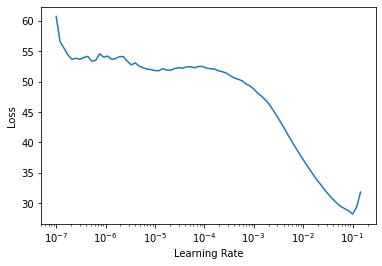

In [90]:
tab_learn.lr_find()

In [93]:
tab_learn.fit_one_cycle(25, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.019249,108.782265,0.298000,00:03
1,0.056483,111.486534,0.342000,00:03
2,0.142426,193.722092,0.291000,00:03
3,0.236678,82.278175,0.299000,00:03
4,0.181559,97.693901,0.309000,00:03
5,0.278333,116.703796,0.322000,00:03
6,0.254204,159.884003,0.324000,00:03
7,0.256991,146.956894,0.280000,00:03
8,0.249356,77.005386,0.327000,00:03
9,0.260395,129.660675,0.312000,00:03


KeyboardInterrupt: 

In [78]:
m = LSTMPlus(dls.vars, 
                    dls.c,
                    hidden_size=200, 
                    n_layers=5, 
                    rnn_dropout=.8,
                    bidirectional=False,
                    fc_dropout=.02)


In [79]:
mixed_dls = get_mixed_dls(dls, tab_dls)

In [80]:
mixed_dls.one_batch()

((TSTensor(samples:64, vars:978, len:180),
  (tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64),
   tensor([[-1.0053, -1.1086, -0.1137,  ..., -0.0764,  0.2057,  0.1283],
           [ 2.6393,  1.4510,  0.9316,  ..., -0.0764,  0.2057,  0.1283],
           [ 2.0291,  1.3179,  0.6234,  ..., -0.0764,  0.2057,  0.1283],
           ...,
           [ 1.5314,  1.4852,  1.1425,  ..., -0.0764,  0.2057,  0.1283],
           [ 0.1861,  1.0411,  2.6730,  ..., -0.0764, -4.8611,  0.1283],
           [ 0.1608, -0.4016,  1.0148,  ..., -0.0764,  0.2057,  0.1283]],
          device='cuda:0'))),
 TensorCategory([0, 1, 3, 1, 1, 3, 3, 2, 3, 1, 0, 3, 2, 1, 3, 3, 0, 1, 0, 1, 1, 1, 2, 2,
         0, 0, 3, 2, 2, 2, 1, 3, 1, 3, 2, 0, 2, 1, 0, 3, 3, 2, 0, 2, 3, 2, 2, 3,
         2, 0, 3, 3, 1, 0, 3, 3, 1, 2, 2, 2, 0, 2, 2, 1], device='cuda:0'))

In [81]:
mm = MultiInputNet(m, tab_model)

In [82]:
learn = Learner(mixed_dls, mm, metrics=accuracy)

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0014454397605732083)

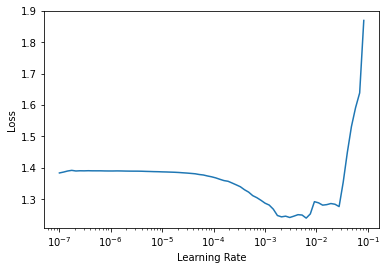

In [83]:
learn.lr_find()

In [87]:
learn.fit_one_cycle(25, lr_max=1e-3)#, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=3)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.055760,48.581604,0.328000,00:30
1,0.044482,46.452900,0.324000,00:30
2,0.034162,45.160057,0.328000,00:30
3,0.027544,46.809299,0.327000,00:30
4,0.022945,49.180462,0.329000,00:30
5,0.021335,56.145828,0.322000,00:30
6,0.018186,63.498764,0.333000,00:30


KeyboardInterrupt: 

In [31]:
ts_features_df_train = pd.read_csv(ml_path + 'tsfresh_features_1_co_Day1DangerAboveTreeline_small.csv', index_col=0)

In [32]:
ts_features_df_train.shape

(5000, 26591)

In [33]:
ts_features_df_test = pd.read_csv(ml_path + 'tsfresh_features_1_co_Day1DangerAboveTreeline_small_test.csv', index_col=0)

In [34]:
ts_features_df_test.shape

(1000, 26591)

In [65]:
ts_features_df = pd.concat([ts_features_df_train, ts_features_df_test])

In [66]:
ts_features_df.reset_index(inplace=True, drop=True)

In [68]:
ts_features_df[4999:5005].head()

,ABSV_300mb_min__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_350mb_min__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_250mb_max__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_100mb_max__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_250mb_min__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_200mb_min__energy_ratio_by_chunks__num_segments_10__segment_focus_7,ABSV_200mb_max__energy_ratio_by_chunks__num_segments_10__segment_focus_7,"ABSV_30mb_min__fft_coefficient__attr_""imag""__coeff_8","ABSV_30mb_min__fft_coefficient__attr_""real""__coeff_9",ABSV_250mb_avg__energy_ratio_by_chunks__num_segments_10__segment_focus_7,...,"ABSV_10mb_avg__fft_coefficient__attr_""real""__coeff_22","ABSV_250mb_min__fft_coefficient__attr_""abs""__coeff_26","ABSV_400mb_min__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""",ABSV_500mb_avg__large_standard_deviation__r_0.2,ABSV_250mb_max__ratio_beyond_r_sigma__r_7,ABSV_1000mb_min__large_standard_deviation__r_0.25,ABSV_50mb_max__variance_larger_than_standard_deviation,ABSV_150mb_max__large_standard_deviation__r_0.2,ABSV_20mb_max__large_standard_deviation__r_0.1,ABSV_350mb_max__symmetry_looking__r_0.05
4999,0.088116,0.061139,0.089569,0.046932,0.150404,0.099431,0.105219,11.455818,-16.363732,0.128216,...,1.336698,18.075196,0.173459,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.852504,-14.733902,0.000000,...,2.106875,1.315579,0.052442,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.517223,-15.031325,0.000000,...,2.243071,0.653067,0.005421,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.807037,-15.395502,0.000000,...,2.157588,1.844325,-0.049047,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.443577,-12.327641,0.000000,...,2.425226,1.207489,0.011954,0.0,0.0,0.0,0.0,0.0,0.0,1.0
